# K-Means Clustering

## 1. Overview

K-Means is a classic **unsupervised learning** algorithm used for **clustering** tasks.  
The goal of K-Means is to partition a dataset into KKK distinct, non-overlapping clusters such that data points within the same cluster are as similar as possible, while data points in different clusters are as dissimilar as possible.

Unlike supervised learning methods, K-Means does **not rely on labeled data**.  
Instead, it discovers hidden structures in the data by grouping observations based solely on feature similarity.

---

## 2. Problem Formulation

Given a dataset

$$\large X = \{x_1, x_2, \dots, x_n\}, \quad x_i \in \mathbb{R}^d$$

the objective of K-Means is to find $\large K$ cluster centers

$$\large \{\mu_1, \mu_2, \dots, \mu_K\}$$

that minimize the **within-cluster sum of squared distances (WCSS)**:

$$\large \min_{\{\mu_k\}} \sum_{k=1}^{K} \sum_{x_i \in C_k} \| x_i - \mu_k \|^2{μk​}$$
where:

- $\large C_k$​ denotes the set of points assigned to cluster $\large k$
    
- $\large \mu_k$​ is the centroid (mean) of cluster $\large k$
    

This objective encourages compact, well-separated clusters.

---

## 3. Algorithm Intuition

K-Means alternates between two simple steps:

### (1) Assignment Step

Each data point is assigned to the nearest cluster centroid based on Euclidean distance.

$$\large \text{label}(x_i) = \arg\min_k \| x_i - \mu_k \|$$

### (2) Update Step

Each centroid is updated as the mean of all data points assigned to that cluster.

$$\large \mu_k = \frac{1}{|C_k|} \sum_{x_i \in C_k} x_i$$

These two steps are repeated until convergence, typically when the centroids move less than a predefined tolerance or when a maximum number of iterations is reached.

---

## 4. Key Characteristics

- **Unsupervised**: No labels are required.
    
- **Distance-based**: Relies heavily on Euclidean distance.
    
- **Iterative**: Alternates between assignment and update steps.
    
- **Sensitive to initialization**: Different initial centroids may lead to different solutions.
    
- **Requires pre-specifying $\large K$**: The number of clusters must be chosen in advance.
    

---

## 5. Practical Applications

K-Means is widely used in real-world applications, including:

- Customer segmentation in marketing
    
- Document clustering and topic discovery
    
- Image compression and color quantization
    
- Exploratory data analysis (EDA)
    
- Anomaly detection (indirectly)
    

In this example, K-Means will be applied to a **real-world customer segmentation dataset from Kaggle**, demonstrating how unsupervised clustering can reveal meaningful patterns in customer behavior.

## 2. Dataset Description

In this example, we use the **Wholesale Customers Dataset**, a real-world dataset
commonly used for customer segmentation and exploratory data analysis.

The dataset contains annual spending information of wholesale customers across
different product categories. The goal is to group customers with similar
purchasing behavior using **unsupervised learning**, making it a natural
application for K-Means clustering.

### Dataset Features

The dataset includes the following columns:

- **Channel**: Customer channel (e.g., retail or horeca)
- **Region**: Customer region
- **Fresh**: Annual spending on fresh products
- **Milk**: Annual spending on milk products
- **Grocery**: Annual spending on grocery products
- **Frozen**: Annual spending on frozen products
- **Detergents_Paper**: Annual spending on detergents and paper products
- **Delicassen**: Annual spending on delicatessen products

All spending-related features are numerical, which makes this dataset well-suited
for distance-based clustering methods such as K-Means.


In [1]:
import pandas as pd

# Load the dataset
data_path = "../../data/Wholesale_customers_data.csv"
df = pd.read_csv(data_path)

# Display the first few rows
df.head()

# Dataset shape
df.shape
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


K-Means relies on distance calculations and therefore requires **numerical features**.

In this dataset:
- All features are numerical and can be directly used for clustering.
- `Channel` and `Region` are encoded as integers but represent categorical information.
  Depending on the analysis goal, they may be excluded or treated separately.
- Spending-related features have very different scales, making **feature scaling
  essential** before applying K-Means.

In the following sections, we will focus on spending behavior and apply feature
scaling before running the K-Means algorithm.


## 3. Data Preprocessing

K-Means is a distance-based algorithm and therefore requires careful preprocessing
to ensure meaningful clustering results.

In this example, we focus on customer spending behavior. The following preprocessing
steps are applied:

- Select numerical spending-related features
- Exclude categorical or identifier-like variables
- Apply feature scaling to normalize different value ranges

Since K-Means relies on Euclidean distance, features with larger numerical ranges
can dominate the clustering process.

To ensure that all features contribute equally, we standardize the data using
z-score normalization.


In [2]:
# Select spending-related numerical features
features = [
    "Fresh",
    "Milk",
    "Grocery",
    "Frozen",
    "Detergents_Paper",
    "Delicassen",
]

X = df[features].values
X.shape

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]

array([[ 0.05293319,  0.52356777, -0.04111489, -0.58936716, -0.04356873,
        -0.06633906],
       [-0.39130197,  0.54445767,  0.17031835, -0.27013618,  0.08640684,
         0.08915105],
       [-0.44702926,  0.40853771, -0.0281571 , -0.13753572,  0.13323164,
         2.24329255],
       [ 0.10011141, -0.62401993, -0.3929769 ,  0.6871443 , -0.49858822,
         0.09341105],
       [ 0.84023948, -0.05239645, -0.07935618,  0.17385884, -0.23191782,
         1.29934689]])

After preprocessing, the dataset is represented as a standardized numerical matrix:

- Each row corresponds to a customer
- Each column corresponds to a spending category
- All features have zero mean and unit variance

This processed dataset is now suitable for applying the K-Means clustering algorithm.


## 4. K-Means Clustering

In this section, we apply the K-Means clustering algorithm to the preprocessed dataset.
The implementation used here is written **from scratch** and follows a scikit-learn–style API.

The algorithm iteratively assigns data points to the nearest cluster center and updates
the centers until convergence.

First specify the number of clusters $K$ and fit the K-Means model to the
standardized data.

In [3]:
from rice_ml.kmeans import KMeans

# Number of clusters
k = 3

# Initialize and fit K-Means
kmeans = KMeans(
    n_clusters=k,
    max_iter=300,
    tol=1e-4,
    random_state=42,
)

labels = kmeans.fit_predict(X_scaled)

labels[:10]

array([1, 2, 2, 1, 1, 1, 1, 1, 1, 2], dtype=int64)

After fitting the model, we examine the learned cluster centers and the assignment
of data points to clusters.

For convenience, the cluster labels are added to the original dataset for inspection
and visualization in later sections.

In [4]:
# Cluster centers (in standardized feature space)
kmeans.cluster_centers_

# Inertia (within-cluster sum of squared distances)
kmeans.inertia_

df_clustered = df.copy()
df_clustered["Cluster"] = labels

df_clustered.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,12669,9656,7561,214,2674,1338,1
1,2,3,7057,9810,9568,1762,3293,1776,2
2,2,3,6353,8808,7684,2405,3516,7844,2
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,1


## 5. Visualization of K-Means Clusters (via PCA)

K-Means clustering is performed in the original high-dimensional feature space.
However, visualizing clusters in more than two dimensions is not straightforward.

To visualize the clustering results, **Principal Component Analysis (PCA)** is used
to project the data into a two-dimensional space.

**Important note**:
- K-Means clustering is performed on the original standardized data.
- PCA is applied *after clustering* and is used **only for visualization**.


In [5]:
from sklearn.decomposition import PCA

# Fit PCA on the scaled data
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Project cluster centers to the same PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)

X_pca.shape, centers_pca.shape


((440, 2), (3, 2))

The scatter plot below shows the K-Means clustering results after projecting
the data onto the first two principal components.

Each point represents a customer, colored by its **K-Means cluster assignment**.
Cluster centers learned by K-Means are shown as larger markers.


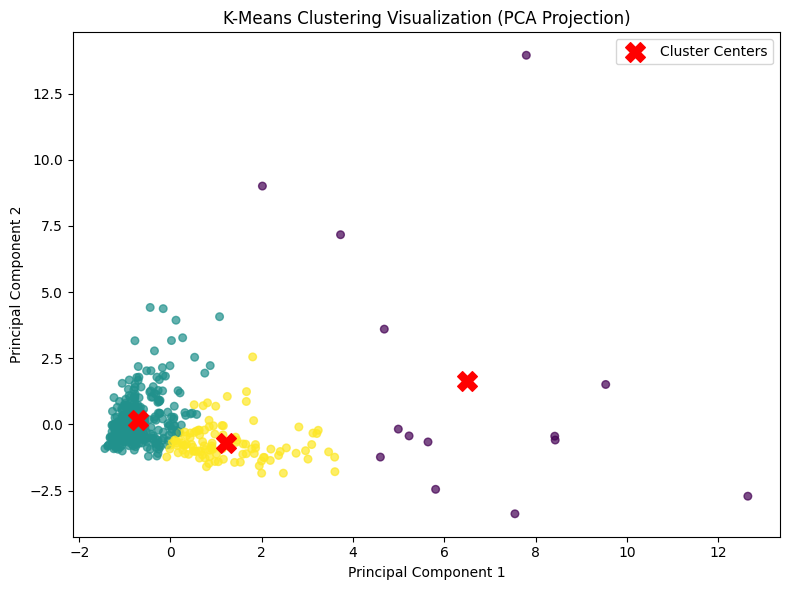

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot data points
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels,
    cmap="viridis",
    s=30,
    alpha=0.7,
)

# Plot cluster centers
plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    c="red",
    s=200,
    marker="X",
    label="Cluster Centers",
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering Visualization (PCA Projection)")
plt.legend()
plt.tight_layout()
plt.show()


## 6. Choosing the Number of Clusters (Elbow Method)

One important limitation of K-Means is that the number of clusters \( K \) must be
specified in advance.

To guide the selection of an appropriate number of clusters, we use the **Elbow Method**.
This method examines how the within-cluster sum of squared distances (inertia) changes
as the number of clusters increases.

As $K$ increases:
- Clusters become smaller and more compact
- The inertia (within-cluster variance) decreases

However, beyond a certain point, increasing $K$ yields only marginal improvement.
This point of diminishing returns is referred to as the **elbow**, and it provides a
reasonable trade-off between model complexity and clustering quality.



In [7]:
# Compute inertia for different values of K
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans_tmp = KMeans(
        n_clusters=k,
        max_iter=300,
        tol=1e-4,
        random_state=42,
    )
    kmeans_tmp.fit(X_scaled)
    inertias.append(kmeans_tmp.inertia_)

inertias


[2640.0,
 1954.0416346097834,
 1614.5183504384177,
 1357.378993322397,
 1230.469370192111,
 1130.406356597825,
 1076.2061661081093,
 833.5947523012844,
 757.7107643928532,
 705.2644810356933]

The following plot shows inertia as a function of the number of clusters.
The "elbow" in the curve suggests a suitable choice for $K$.


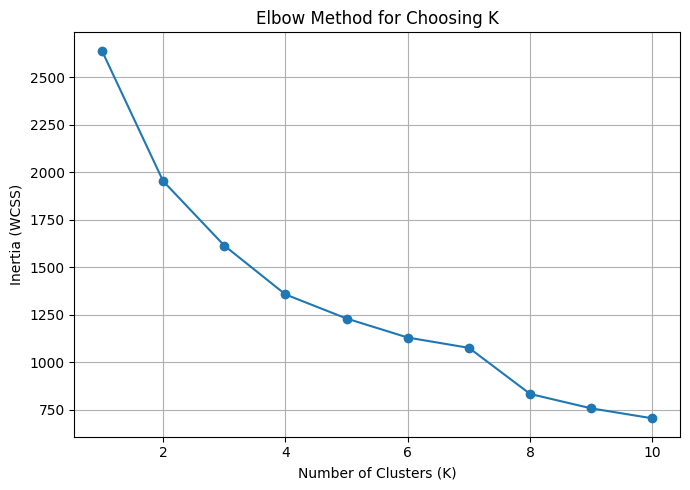

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(k_values, inertias, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Choosing K")
plt.grid(True)
plt.tight_layout()
plt.show()


## 7. Summary & Key Takeaways

In this example, we implemented the K-Means clustering algorithm from scratch and
applied it to a real-world customer dataset.

Key steps and observations include:

- K-Means clustering was implemented using NumPy with a scikit-learn–style API.
- Proper preprocessing, especially **feature scaling**, is essential for
  distance-based clustering algorithms.
- The clustering process iteratively alternates between assignment and centroid
  update steps until convergence.
- PCA was applied **only for visualization**, allowing the clustering structure
  to be visualized in two dimensions without affecting the clustering results.
- The Elbow Method was used to analyze how inertia changes with the number of
  clusters and to guide the selection of an appropriate value of \( K \).

Overall, this example demonstrates how K-Means can be used as an effective
unsupervised learning method for discovering structure in high-dimensional data.
